In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
import prodimopy.plot as pplot
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve
from scipy.optimize import minimize

In [4]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def add_noise(flux, SNR):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise


In [5]:
cmap = mpl.colormaps.get_cmap('tab20')

In [6]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
data = []
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)

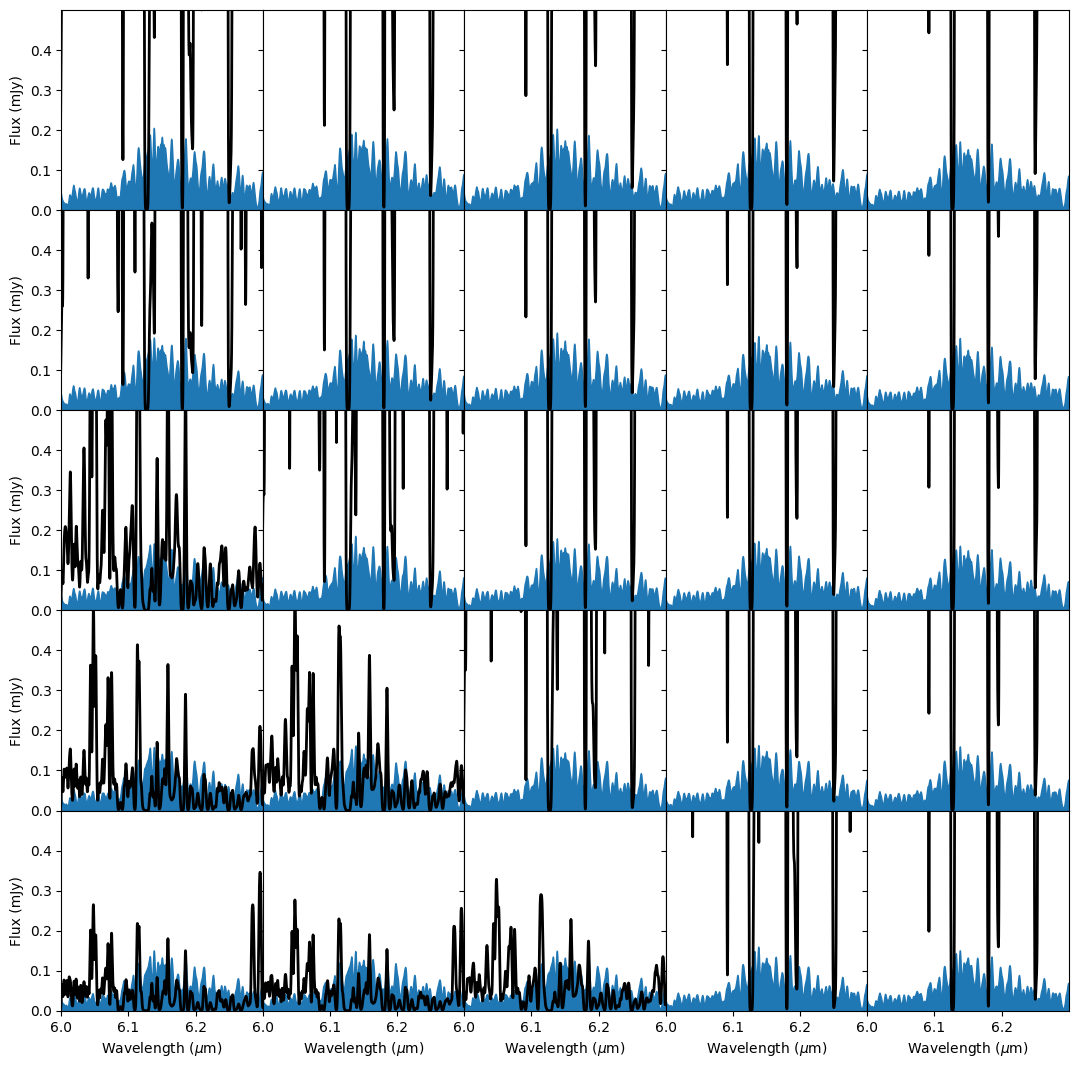

In [8]:
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[6, 6.3]
yrange=[0,0.5]
num_xticks = 4
num_yticks = 6
total_spec= None
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_flux = row['FLiTs Flux']
    total_wl = row['FLiTs Wavelength']
    for index, specie in enumerate(species):
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_wl = row[f'FLiTs {specie} Wavelength']
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[i].fill_between(specie_wl, 0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(total_wl, total_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

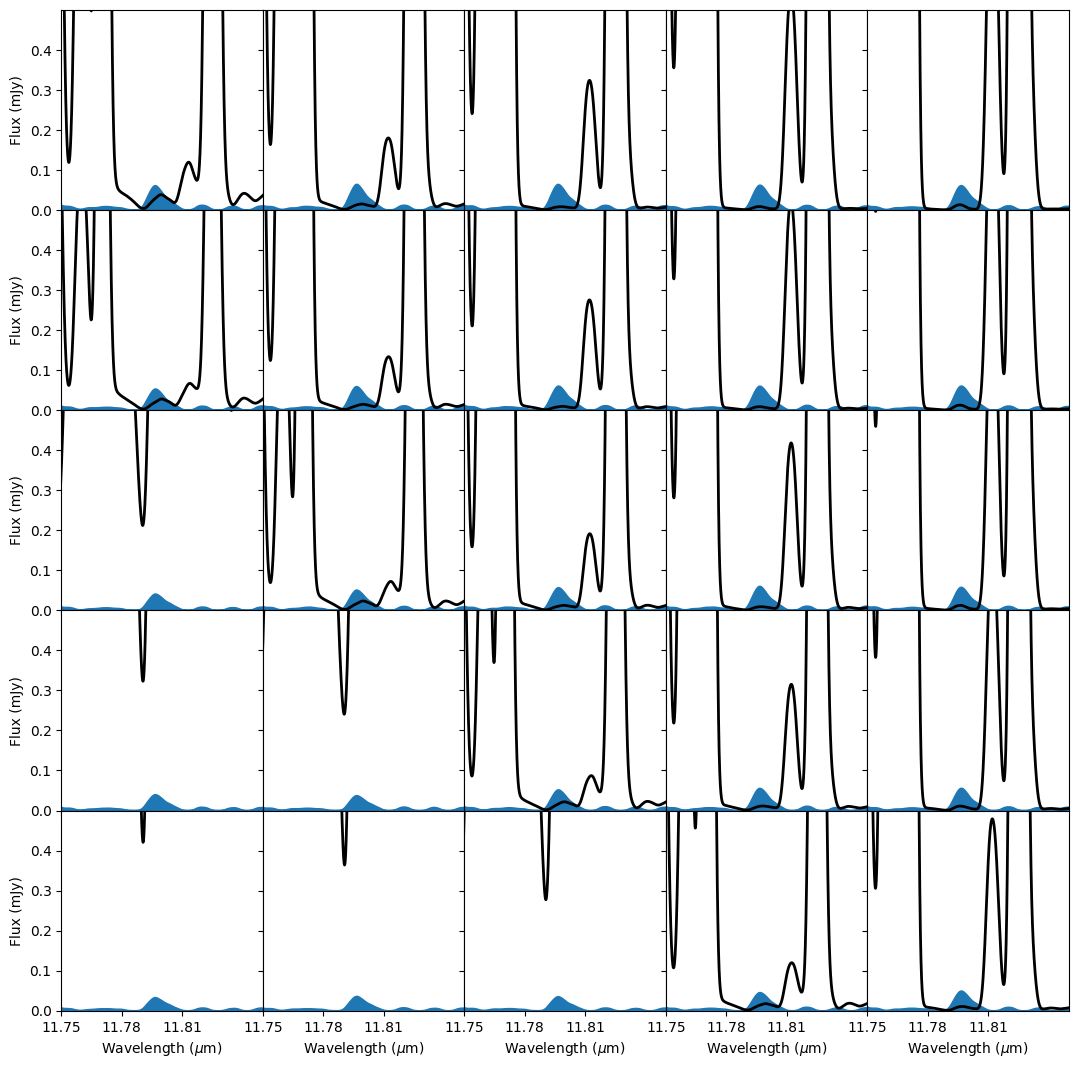

In [9]:
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[11.75, 11.85]
yrange=[0,0.5]
num_xticks = 4
num_yticks = 6
total_spec= None
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_flux = row['FLiTs Flux']
    total_wl = row['FLiTs Wavelength']
    for index, specie in enumerate(species):
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_wl = row[f'FLiTs {specie} Wavelength']
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[i].fill_between(specie_wl, 0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(total_wl, total_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

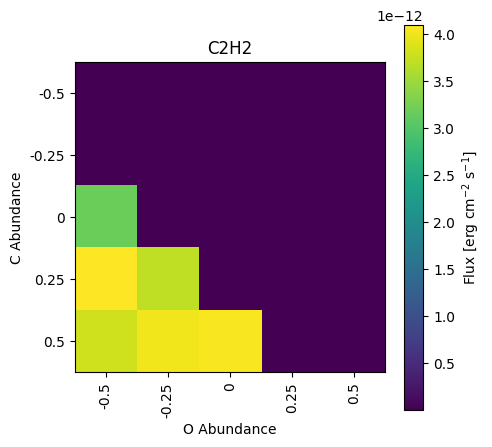

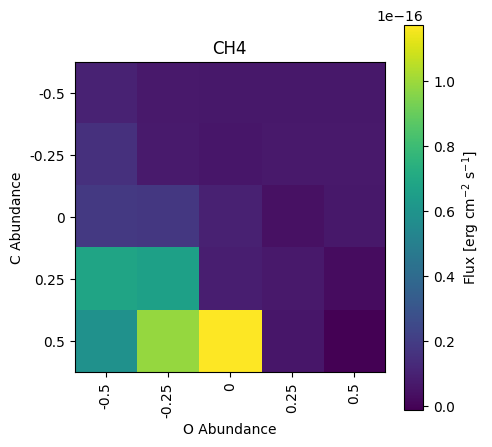

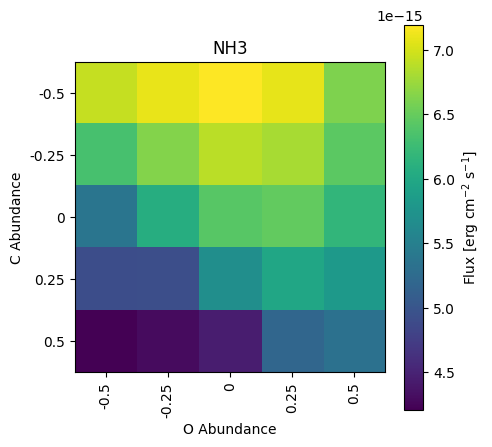

In [10]:
for specie in ['C2H2', 'CH4', 'NH3']:
    plt.figure(figsize=(5, 5))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    plt.show()

In [11]:
model_index = 20
model_flits = pread.read_FLiTs('gdr_1000_N/' + df['Model Name'][model_index], filename='specFLiTs1.out')
wl, flux_without_NH3, flux_cont = model_flits.convolve(3000, contReturn=True)

NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
NH3_flux = np.interp(wl, NH3_wl, NH3_flux)
NH3_flux_cont = np.interp(wl, NH3_wl, NH3_flux_cont)
flux_with_NH3 = flux_without_NH3 + NH3_flux - NH3_flux_cont

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

np.random.seed(42)
noise_flux = add_noise(flux_with_NH3, 300)
ax1.plot(wl, (noise_flux - flux_cont) * 1000, label='Flux with NH3')

np.random.seed(42)
noise_flux = add_noise(flux_without_NH3, 300)
ax1.plot(wl, (noise_flux - flux_cont) * 1000, label='Flux without NH3')

ax1.set_title('Signal with Noise')
ax1.set_ylabel('Flux (mJy)')
ax1.set_xlim(6, 6.4)
ax1.set_ylim(0, 5)
ax1.legend()

ax2.plot(wl, (flux_with_NH3 - flux_cont) * 1000, label='Flux with NH3')
ax2.plot(wl, (flux_without_NH3 - flux_cont) * 1000, label='Flux without NH3')
ax2.set_title('Signal without Noise')
ax2.set_xlabel(r'Wavelength ($\mu$m)')
ax2.set_ylabel('Flux (mJy)')
ax2.legend()
plt.show()

WARN: Could not open gdr_1000_N/C_0.5_O_-0.5_CO_4.57\specFLiTs1.out!


AttributeError: 'tuple' object has no attribute 'convolve'

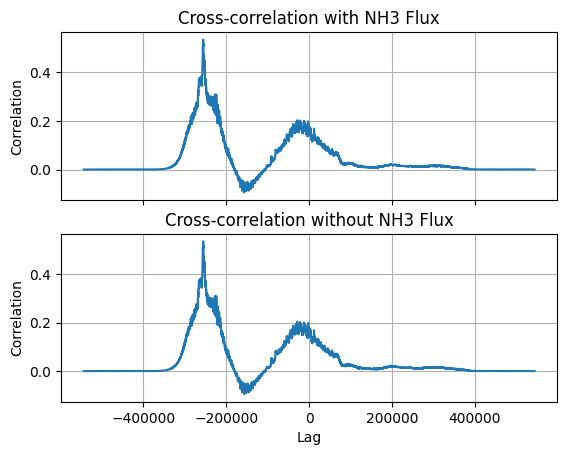

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

np.random.seed(42)
noise_flux = add_noise(flux_with_NH3, 300)
cc1 = fftconvolve((NH3_flux - NH3_flux_cont), (noise_flux - flux_cont)[::-1], mode='full')
lags = np.arange(-len(noise_flux)+1, len(NH3_flux))
ax1.plot(lags, cc1)
ax1.set_title("Cross-correlation with NH3 Flux")
ax1.set_ylabel("Correlation")
ax1.grid(True)


np.random.seed(42)
noise_flux = add_noise(flux_without_NH3, 300)
cc2 = fftconvolve((NH3_flux - NH3_flux_cont), (noise_flux - flux_cont)[::-1], mode='full')
lags = np.arange(-len(noise_flux)+1, len(NH3_flux))
ax2.plot(lags, cc2)
ax2.set_title("Cross-correlation without NH3 Flux")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Correlation")
ax2.grid(True)
plt.show()

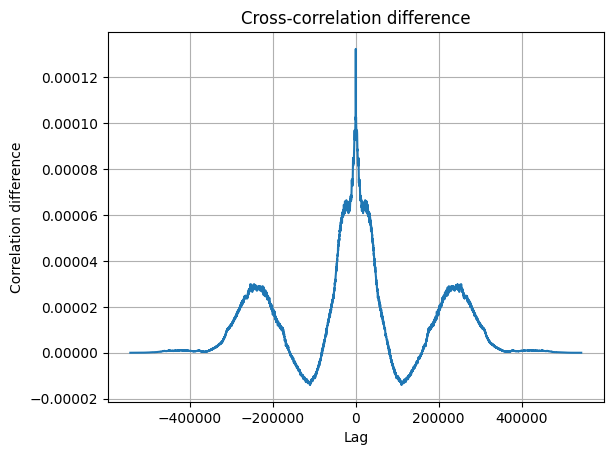

In [11]:
# Plotting the difference between the crosscorrelations
plt.plot(lags, cc1-cc2)
plt.title("Cross-correlation difference")
plt.xlabel("Lag")
plt.ylabel("Correlation difference")
plt.grid(True)
plt.show()

In [12]:
# Making all the arrays on a uniform wavelength grid
wl_uniform = np.linspace(min(wl), max(wl), len(wl))
flux_without_NH3_uniform = np.interp(wl_uniform, wl, flux_without_NH3)
flux_with_NH3_uniform = np.interp(wl_uniform, wl, flux_with_NH3)
flux_cont_uniform = np.interp(wl_uniform, wl, flux_cont)
np.random.seed(42)
noise_flux_with_NH3_uniform = add_noise(flux_with_NH3_uniform, 300)
NH3_flux_uniform = np.interp(wl_uniform, wl, NH3_flux)
NH3_flux_cont_uniform = np.interp(wl_uniform, wl, NH3_flux_cont)
np.random.seed(42)
noise_flux_without_NH3_uniform = add_noise(flux_without_NH3_uniform, 300)

NH3_flux_uniform -= NH3_flux_cont_uniform
noise_flux_with_NH3_uniform -= flux_cont_uniform
noise_flux_without_NH3_uniform -= flux_cont_uniform

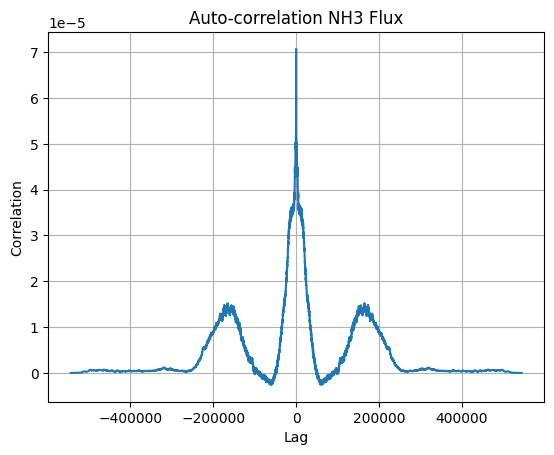

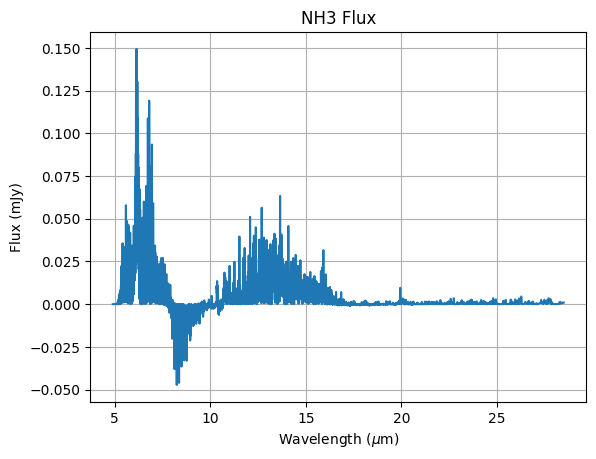

In [13]:
ac = fftconvolve(NH3_flux_uniform, NH3_flux_uniform[::-1], mode='full')
lags = np.arange(-len(NH3_flux_uniform)+1, len(NH3_flux_uniform))

# Plotting the autocorrelation of NH3
plt.plot(lags, ac)
plt.title('Auto-correlation NH3 Flux')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

# Plotting NH3
plt.plot(wl_uniform, NH3_flux_uniform*1000)
plt.title("NH3 Flux")
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (mJy)')
plt.grid(True)
plt.show()

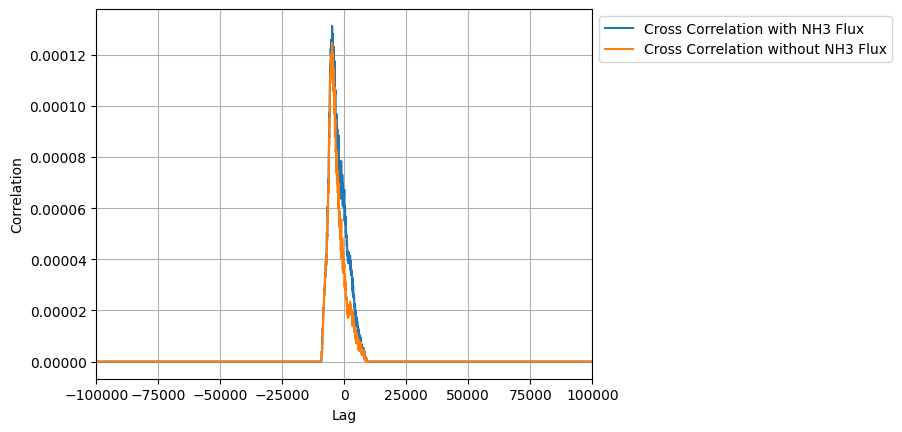

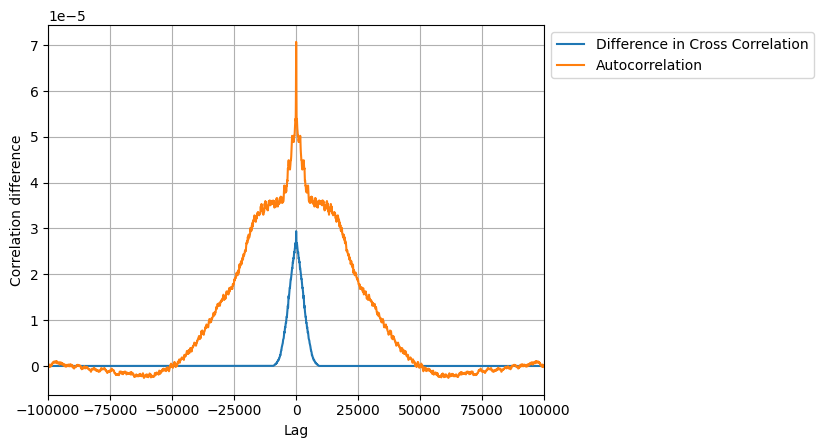

In [14]:
new_noise_flux = noise_flux_with_NH3_uniform.copy()
new_NH3_flux = NH3_flux_uniform.copy()
new_noise_wout_NH3_flux = noise_flux_without_NH3_uniform.copy()

wl_mask = (wl_uniform < 6) | (wl_uniform > 6.4)
flux_treshold = 0.1

# Masking the array
new_noise_flux[wl_mask] = 0
new_noise_flux[new_noise_flux>flux_treshold] = 0
new_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

# Calculating the crosscorrelation
cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')

# Comparing the crosscorrelations for the signals with and without NH3
plt.plot(lags, cc_with, label='Cross Correlation with NH3 Flux')
plt.plot(lags, cc_without, label='Cross Correlation without NH3 Flux')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-100000, 100000)
plt.show()

# Comparing the difference and the autocorrelation
plt.plot(lags, cc_with - cc_without, label='Difference in Cross Correlation')
plt.plot(lags, ac, label='Autocorrelation')
plt.xlabel("Lag")
plt.ylabel("Correlation difference")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-100000, 100000)
plt.show()

In [15]:
def difference(params):
    a,b,c = params
    new_noise_flux = noise_flux_with_NH3_uniform.copy()
    new_NH3_flux = NH3_flux_uniform.copy()
    new_noise_wout_NH3_flux = noise_flux_without_NH3_uniform.copy()

    wl_mask = (wl_uniform < a) | (wl_uniform > b)
    flux_treshold = c

    new_noise_flux[wl_mask] = 0
    new_noise_flux[new_noise_flux>flux_treshold] = 0
    new_NH3_flux[wl_mask] = 0
    # new_NH3_flux[new_NH3_flux>flux_treshold] = 0
    new_noise_wout_NH3_flux[wl_mask] = 0
    new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

    cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
    cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
    return -abs(cc_with[lags==0]-cc_without[lags==0])/abs(b-a+1)

initial_guess = [6, 6.4, 0.1]

result = minimize(difference, initial_guess, method='Nelder-Mead')

best_params = result.x

[6.0450756  6.3024475  0.10686546]


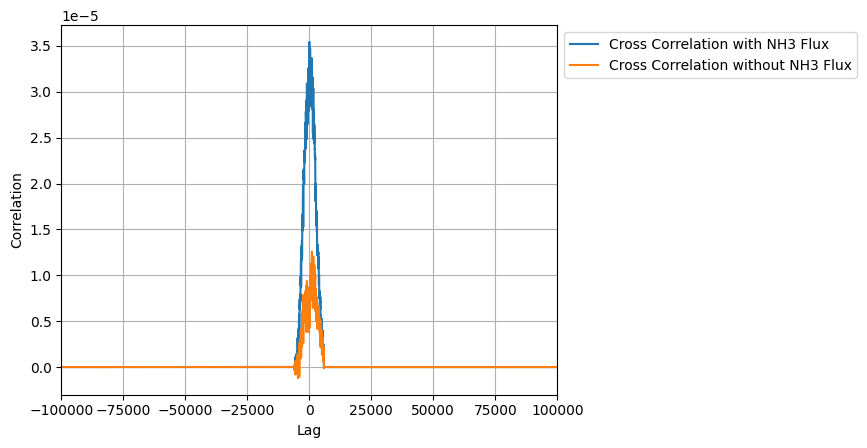

In [16]:
print(best_params)
new_noise_flux = noise_flux_with_NH3_uniform.copy()
new_NH3_flux = NH3_flux_uniform.copy()
new_noise_wout_NH3_flux = noise_flux_without_NH3_uniform.copy()

wl_mask = (wl_uniform < best_params[0]) | (wl_uniform > best_params[1])
flux_treshold = best_params[2]

new_noise_flux[wl_mask] = 0
new_noise_flux[new_noise_flux>flux_treshold] = 0
new_NH3_flux[wl_mask] = 0
# new_NH3_flux[new_NH3_flux>flux_treshold] = 0
new_noise_wout_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
# Comparing the crosscorrelations for the signals with and without NH3
plt.plot(lags, cc_with, label='Cross Correlation with NH3 Flux')
plt.plot(lags, cc_without, label='Cross Correlation without NH3 Flux')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-100000, 100000)
plt.show()

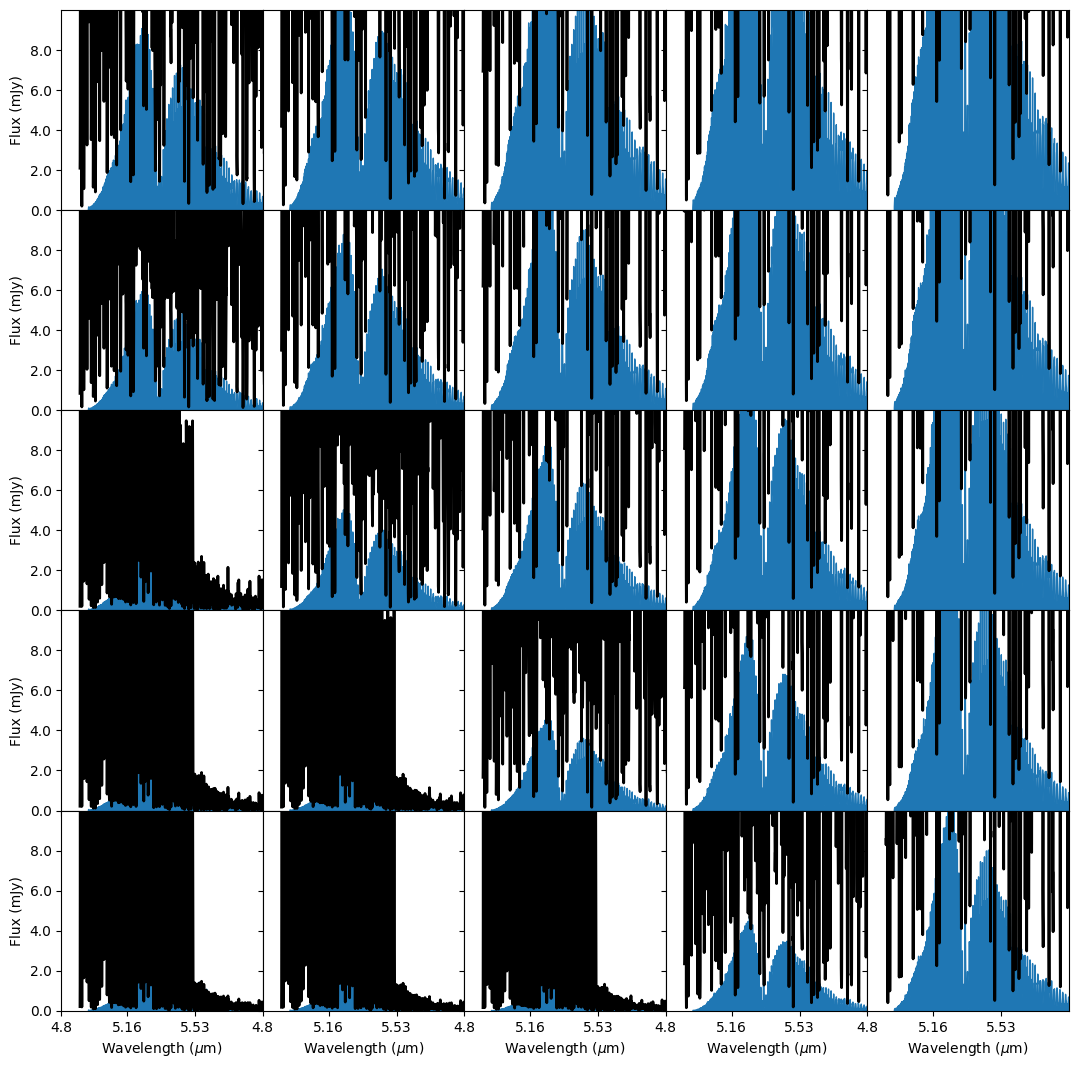

In [17]:
species =['NO']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[4.8, 5.9]
yrange=[0,10]
num_xticks = 4
num_yticks = 6
total_spec= None
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_flux = row['FLiTs Flux']
    total_wl = row['FLiTs Wavelength']
    for index, specie in enumerate(species):
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_wl = row[f'FLiTs {specie} Wavelength']
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[i].fill_between(specie_wl, 0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(total_wl, total_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

In [18]:
gdr = '1000'
with open(f'FLiTsData{gdr}.pkl', 'rb') as f:
    df = pickle.load(f)
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


Max line height
    H2O 4.64924034398089e-12
    CO 6.812713644300617e-13
    NO 1.3583139652913537e-13
    CH4 8.78398771280297e-17
    NH3 3.3807569385100874e-15


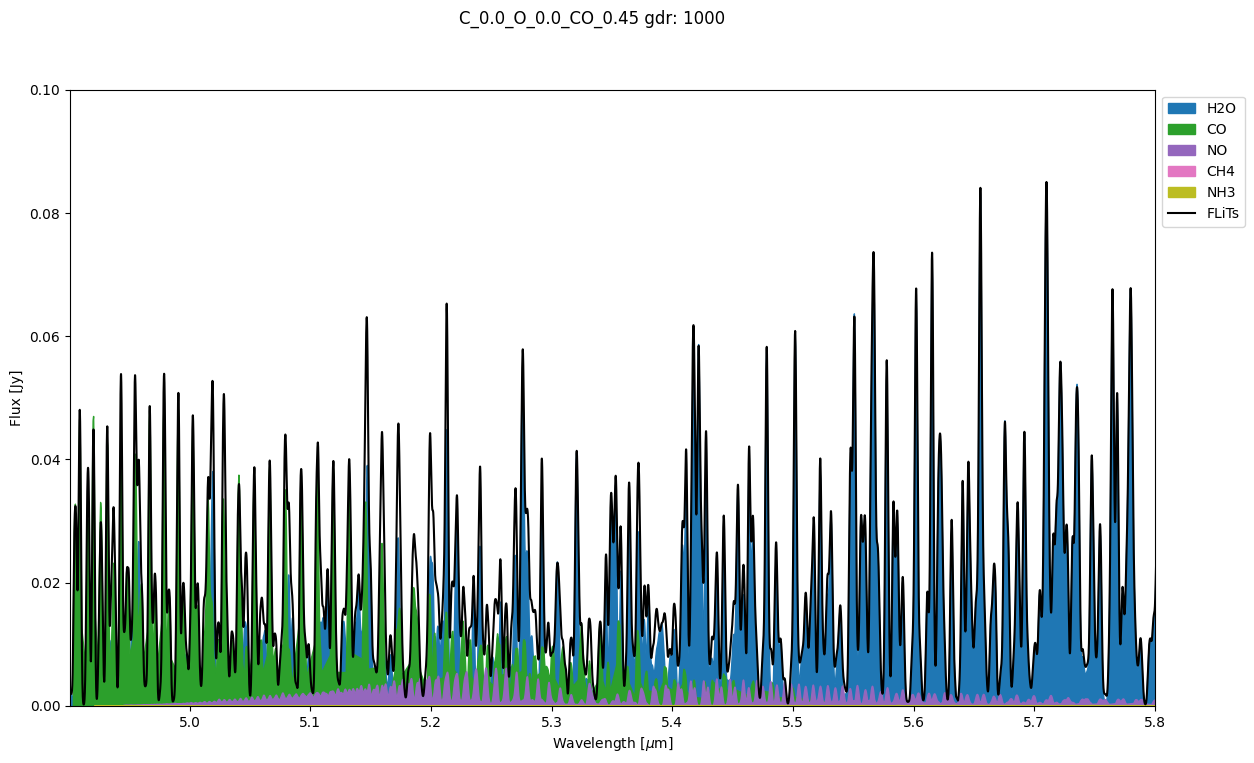

In [19]:
cmap = mpl.colormaps.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(14, 8))
species = ['H2O','CO','NO', 'CH4', 'NH3']
model = df['Model Name'][12]
print('Max line height')
for index, specie in enumerate(species):
    ax.fill_between(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy(), 0, df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy(), label=specie, zorder=index,
                    color=cmap(index / len(species)))
    print('   ',specie, total_flux(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy(), df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()))
ax.plot(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(),
        df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), label='FLiTs', color='black',
        zorder=20)
fig.suptitle(model+' gdr: '+gdr[:4]+' ')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim([4.901, 5.8])
ax.set_ylim(0,0.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [20]:
print(1.3583139652913537e-13/(3.3807569385100874e-15))

40.17780603564975


In [21]:
with open('ProDiMoData1000.pkl', 'rb') as f:
    models = pickle.load(f)

[['NO_H', 5.22197342]]
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_abuncont ...


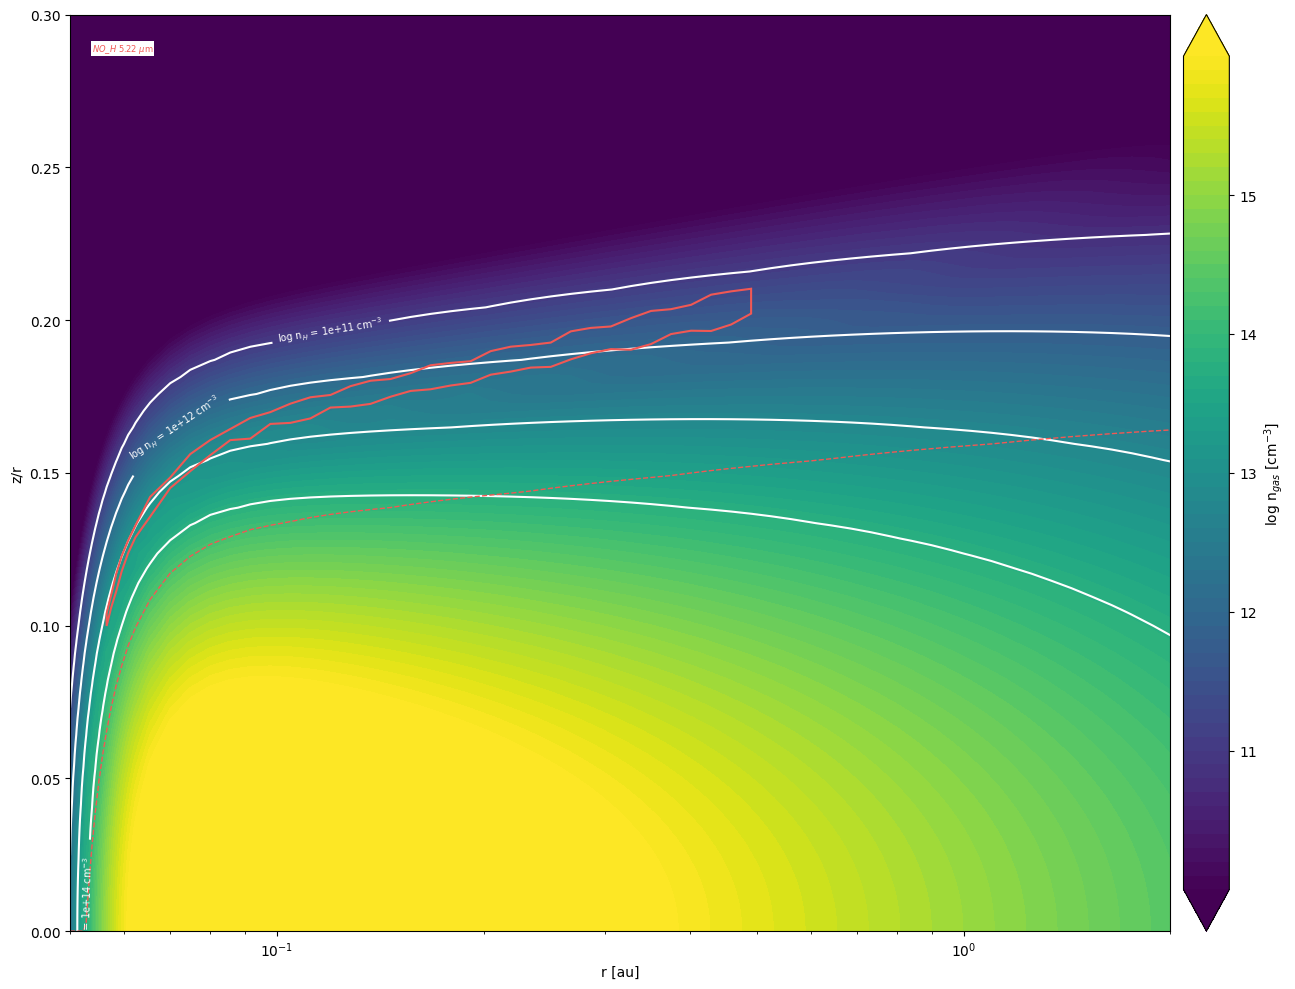

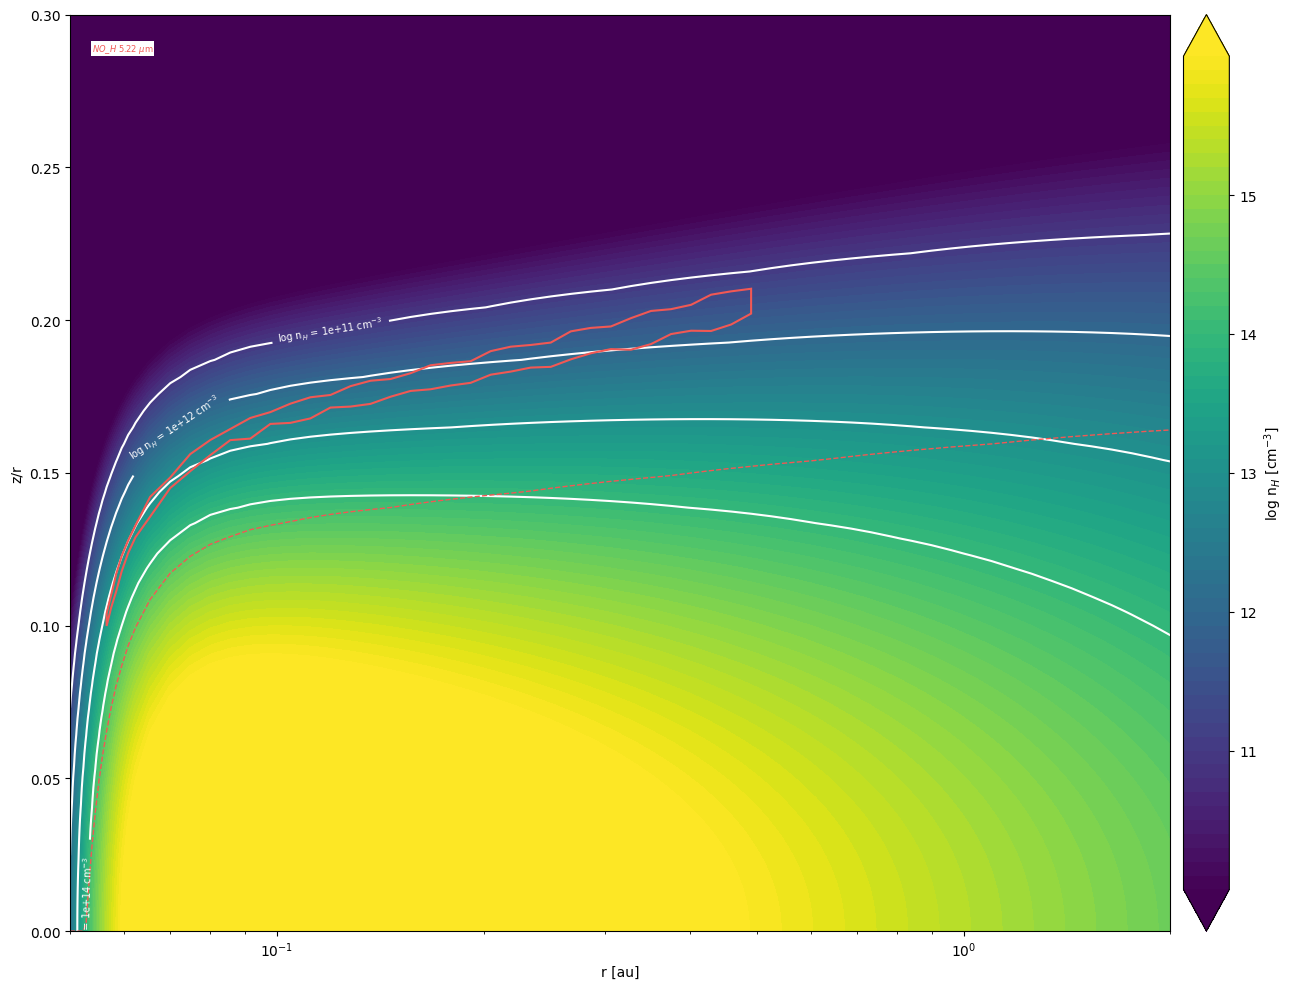

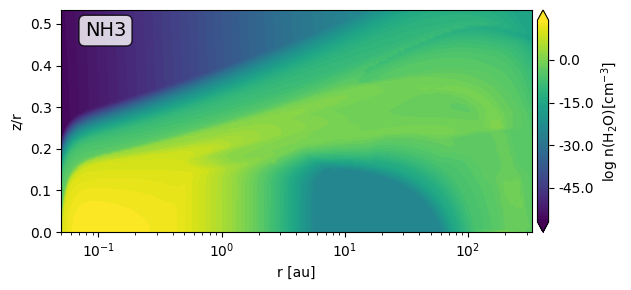

In [37]:
fig, ax = plt.subplots(figsize=(14, 10))
for i, model in enumerate(models):
    if i != 12:
        continue
    lines=model.selectLineEstimates(ident="NO_H",wlrange=[4.9,28])
    lines=sorted(lines,key=lambda x: x.flux,reverse=True)[:1]
    line_ident = [['NO_H', x.wl] for x in lines]
    print(line_ident)
    # print(type(lines[0]))
    # lines=sorted(lines,key=lambda x: x.flux,reverse=True)[:50]
    # mask = model.getLineOriginMask(lines)
    pp=pplot.Plot(None)
    cont=pplot.Contour(model.nHtot,[1e11, 1e12, 1e13, 1e14],label_fmt=r"log n$_{H}$ = %.0e cm$^{-3}$",colors="white",linestyles="-",showlabels=True)
    # cbticks = [10, 30, 100, 300, 1000]
    fig=pp.plot_line_origin(model,line_ident,field=np.sum(model.nmol, axis=-1) ,
                            label=r"log n$_{gas}$ [cm$^{-3}$]",extend="both",cb_format="%.0f",zr=True,xlog=True, zlim=[1e10, 1e16],
                            xlim=[None,2],ylim=[None,0.3], showcb=True,
                            showContOrigin=False,showRadialLines=False, ax=ax,  oconts=[cont]) # this adds an additional contour
    # fig=pp.plot_abuncont(model, species='NO', contour=False,ax=ax, xlim=[None,1])
    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(14, 10))
    fig=pp.plot_line_origin(model,line_ident,field=model.nHtot,
                            label=r"log n$_{H}$ [cm$^{-3}$]",extend="both",cb_format="%.0f",zr=True,xlog=True, zlim=[1e10, 1e16],
                            xlim=[None,2],ylim=[None,0.3], showcb=True,
                            showContOrigin=False,showRadialLines=False, ax=ax,  oconts=[cont]) # this adds an additional contour
    # fig=pp.plot_abuncont(model, species='NO', contour=False,ax=ax, xlim=[None,1])
    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(6.5, 3))
    fig = pp.plot_abuncont(model, 'H2O', extend="both", cb_format="%.1f", contour=False,
                           ax=ax,  rel2H=False)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, specie, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.tight_layout()
plt.show()
    # print(*waterlines, sep="\n")

In [29]:
new_df = pd.DataFrame(data=np.sum(model.nmol, axis=-1))
new_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.477015e+12,1.476419e+12,1.473613e+12,1.467274e+12,1.456218e+12,1.439361e+12,1.415732e+12,1.384557e+12,1.345257e+12,1.297511e+12,...,219.743440,219.743447,219.743453,219.743460,219.743467,219.743474,219.743482,219.743489,219.743397,219.743414
1,2.592141e+12,2.591114e+12,2.586200e+12,2.575098e+12,2.555724e+12,2.526196e+12,2.484873e+12,2.430105e+12,2.361071e+12,2.277190e+12,...,219.743455,219.743462,219.743470,219.743476,219.743483,219.743490,219.743397,219.743405,219.743413,219.743431
2,4.568321e+12,4.566494e+12,4.557823e+12,4.538279e+12,4.504158e+12,4.452148e+12,4.380490e+12,4.284421e+12,4.163249e+12,4.015966e+12,...,219.743472,219.743479,219.743486,219.743393,219.743400,219.743407,219.743415,219.743423,219.743440,219.743449
3,8.049451e+12,8.046384e+12,8.031270e+12,7.996998e+12,7.937096e+12,7.845654e+12,7.717398e+12,7.548160e+12,7.334758e+12,7.075440e+12,...,219.743489,219.743397,219.743404,219.743411,219.743418,219.743426,219.743433,219.743451,219.743459,219.743468
4,1.415985e+13,1.415538e+13,1.412996e+13,1.407069e+13,1.396639e+13,1.380679e+13,1.358248e+13,1.328613e+13,1.291228e+13,1.245767e+13,...,219.743408,219.743415,219.743422,219.743430,219.743437,219.743444,219.743462,219.743471,219.743480,219.743489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5.228347e+05,2.939944e+05,2.958417e+05,2.976128e+05,2.996877e+05,3.023057e+05,3.057414e+05,3.103634e+05,3.167319e+05,3.255820e+05,...,241.268510,186.486860,143.590522,112.375553,114.698647,115.803427,116.536375,117.060579,117.421238,117.657499
146,3.240339e+05,1.866749e+05,1.899086e+05,1.932908e+05,1.975653e+05,2.033013e+05,2.111428e+05,2.218228e+05,2.358949e+05,2.531128e+05,...,163.206067,126.585932,110.891920,111.856413,114.283180,115.537568,116.278194,116.795909,117.149545,117.380510
147,2.196938e+05,1.322686e+05,1.372121e+05,1.426215e+05,1.495744e+05,1.587192e+05,1.702427e+05,1.833033e+05,1.957955e+05,2.052356e+05,...,118.476237,110.498591,110.820188,111.640153,113.865691,115.317619,116.074355,116.589609,116.938549,117.165963
148,1.665348e+05,1.059462e+05,1.123539e+05,1.193441e+05,1.278654e+05,1.377654e+05,1.477068e+05,1.556823e+05,1.601449e+05,1.623761e+05,...,110.301698,110.474168,110.776040,111.523563,113.559785,115.155787,115.931317,116.446594,116.793096,117.018225


In [14]:
specie = 'NH3'
def difference(params):
    a,b,c  = params
    total = 0
    for i, row in df.iterrows():
        if i not in [10, 15, 16, 20, 21, 22]:
            continue
        wl = row['FLiTs Wavelength']
        NH3_wl_old = row['FLiTs NH3 Wavelength']
        NH3_wl = np.linspace(5, 28, 100000)
        wl_mask = (NH3_wl < a) | (NH3_wl > b)
        NH3_flux = np.interp(NH3_wl, NH3_wl_old, row['FLiTs NH3 Flux'])
        flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
        np.random.seed(0)
        flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
        specie_flux[wl_mask] = 0
        flux[wl_mask] = 0
        flux[flux>c] = 0
        cc = fftconvolve((specie_flux), (flux)[::-1], mode='full')
        cc_without = fftconvolve((specie_flux), (flux-specie_flux)[::-1], mode='full')
        lags = np.arange(-len(specie_flux)+1, len(flux))
        total -= abs(cc[lags==0]-cc_without[lags==0])/abs(b-a+1)
    return total

initial_guess = [6.02622319, 6.30250393, 0.98183598]

result = minimize(difference, initial_guess, method='Nelder-Mead')

best_params = result.x
print(best_params)

[6.02627026 6.30250304 1.01266118]


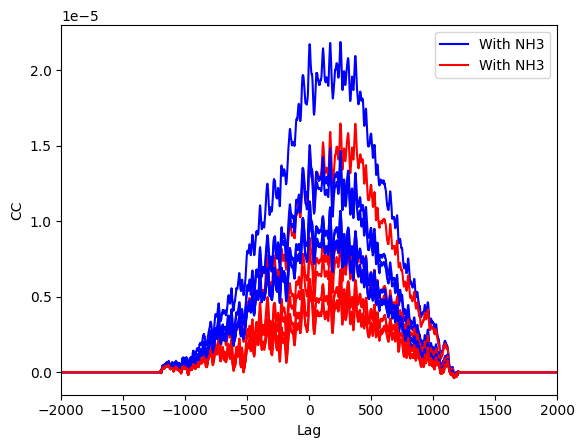

In [15]:
specie = 'NH3'
a,b, c = best_params
for i, row in df.iterrows():
    if i not in [10, 15, 16, 20, 21, 22]:
        continue
    wl = row['FLiTs Wavelength']
    NH3_wl_old = row['FLiTs NH3 Wavelength']
    NH3_wl = np.linspace(5, 28, 100000)
    wl_mask = (NH3_wl < a) | (NH3_wl > b)
    NH3_flux = np.interp(NH3_wl, NH3_wl_old, row['FLiTs NH3 Flux'])
    flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
    flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
    np.random.seed(0)
    flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
    specie_wl = row[f'FLiTs {specie} Wavelength']
    specie_flux = row[f'FLiTs {specie} Flux']
    specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
    specie_flux[wl_mask] = 0
    flux[wl_mask] = 0
    flux[flux>c] = 0
    cc = fftconvolve((specie_flux), (flux)[::-1], mode='full')
    cc_without = fftconvolve((specie_flux), (flux-specie_flux)[::-1], mode='full')
    lags = np.arange(-len(specie_flux)+1, len(flux))
    plt.plot(lags, cc, c='blue')
    plt.plot(lags, cc_without, c='red')
    plt.xlim(-2000, 2000)
    # plt.vlines(0, 0, 0.01, color='black')
plt.plot(lags, cc, c='blue', label='With NH3')
plt.plot(lags, cc_without, c='red', label='With NH3')
plt.legend(loc='upper right')
plt.xlabel('Lag')
plt.ylabel('CC')
plt.show()

25it [00:01, 20.12it/s]


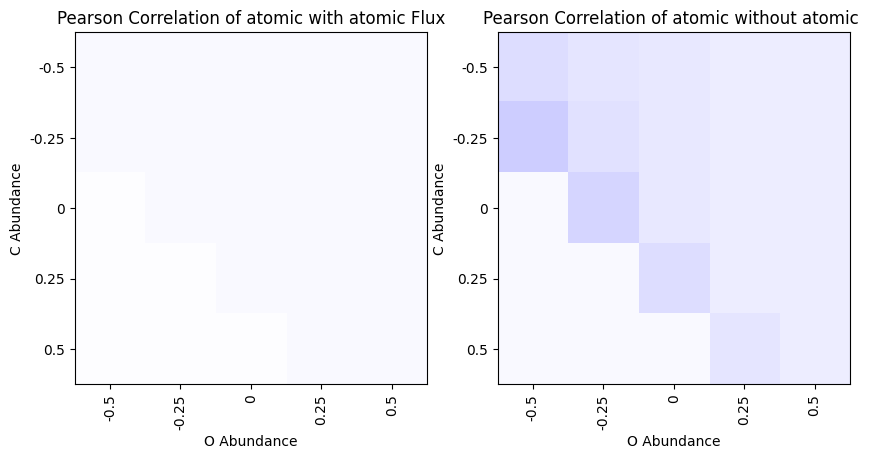

25it [00:01, 19.84it/s]


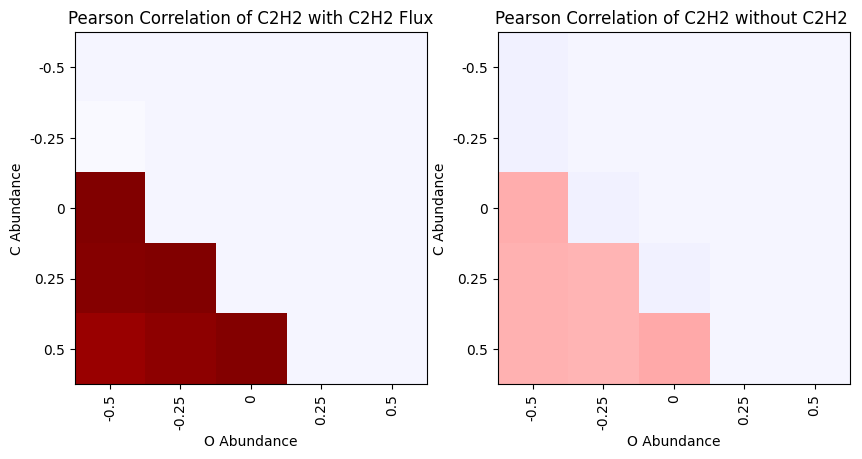

25it [00:01, 20.49it/s]


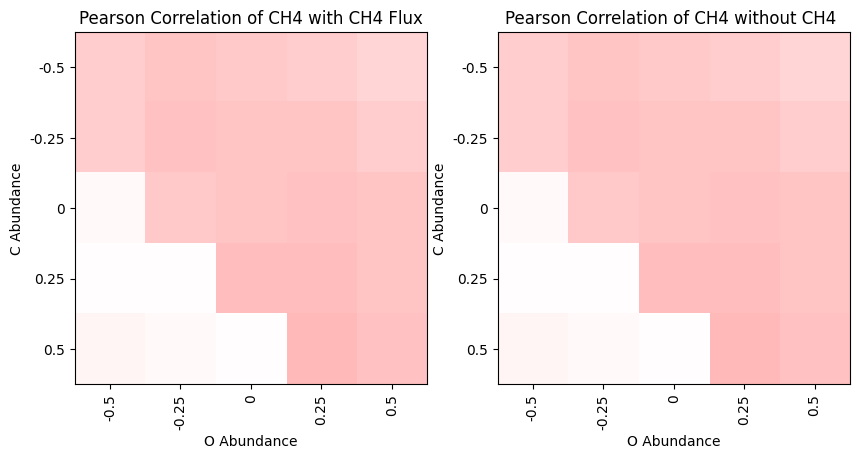

25it [00:01, 20.47it/s]


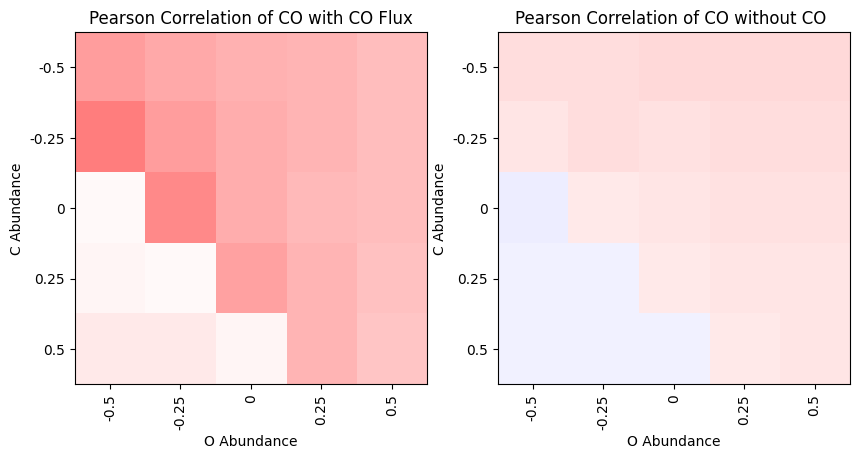

25it [00:01, 20.75it/s]


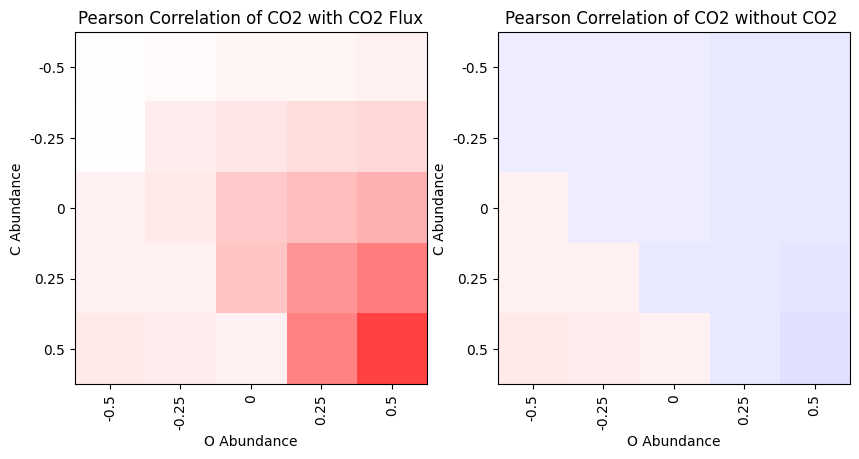

25it [00:01, 19.90it/s]


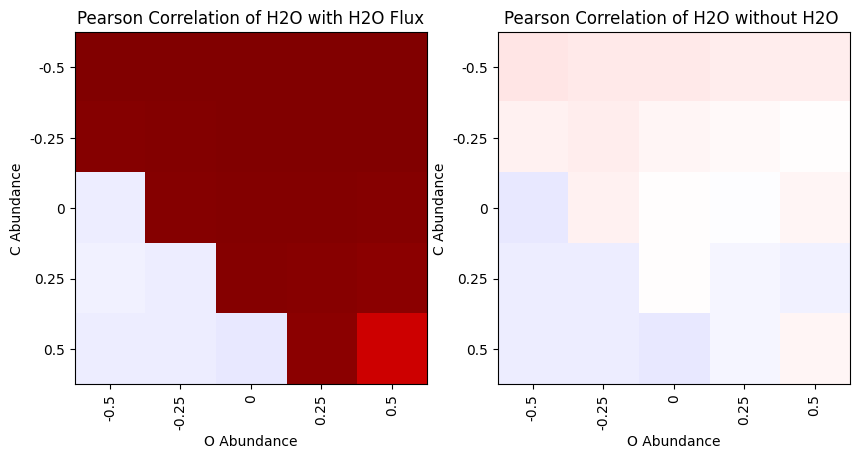

25it [00:01, 20.75it/s]


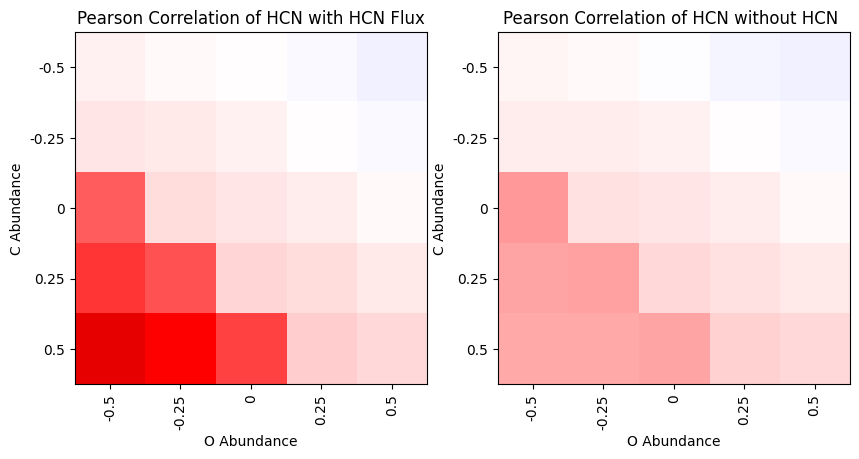

25it [00:01, 20.44it/s]


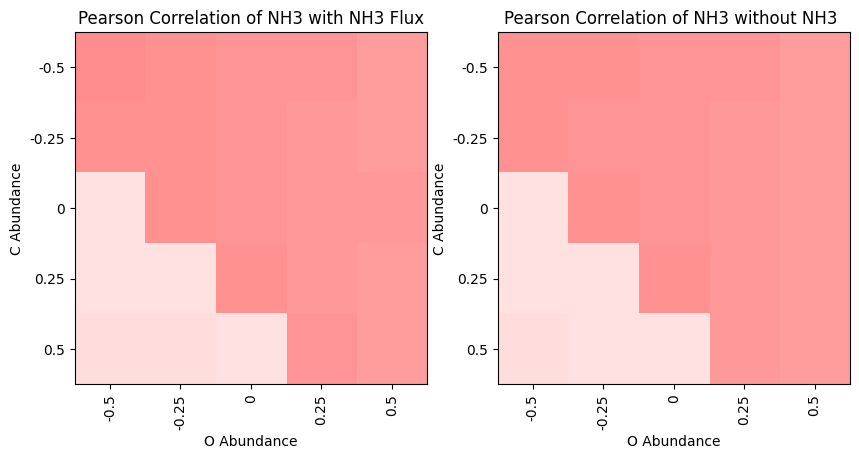

25it [00:01, 20.72it/s]


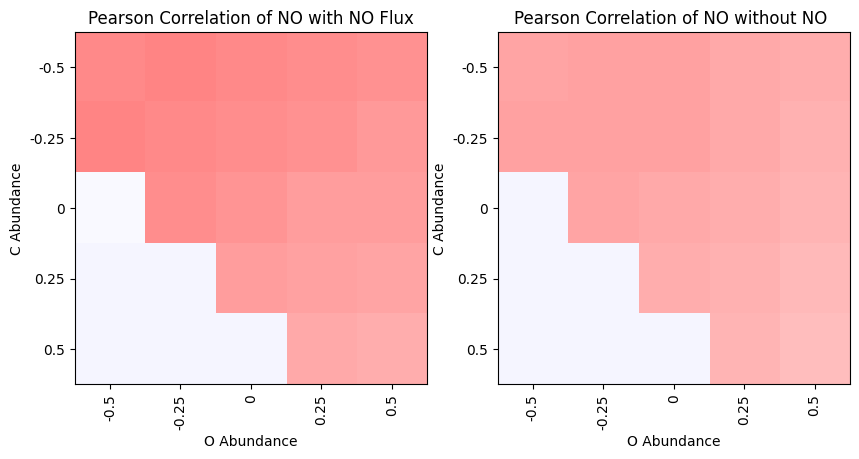

9it [00:00, 20.36it/s]C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_18632\4117752606.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr.append(pearsonr(flux, specie_flux)[0])
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_18632\4117752606.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr_without.append(pearsonr(flux-specie_flux, specie_flux)[0])
25it [00:01, 20.24it/s]


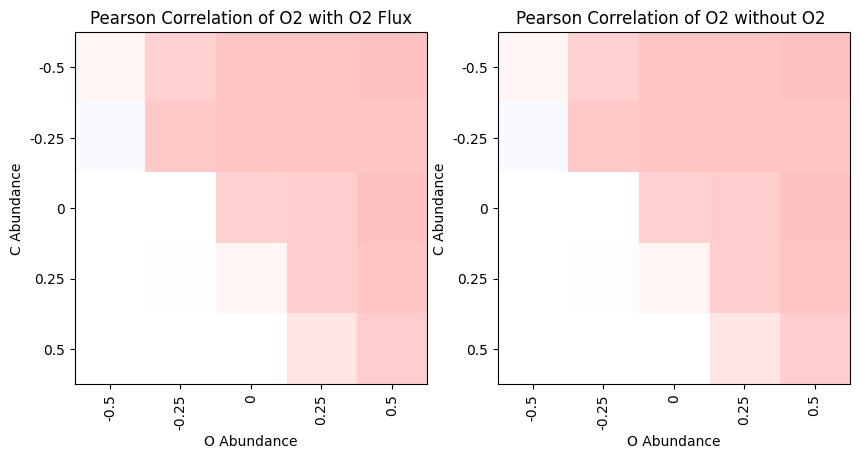

25it [00:01, 20.21it/s]


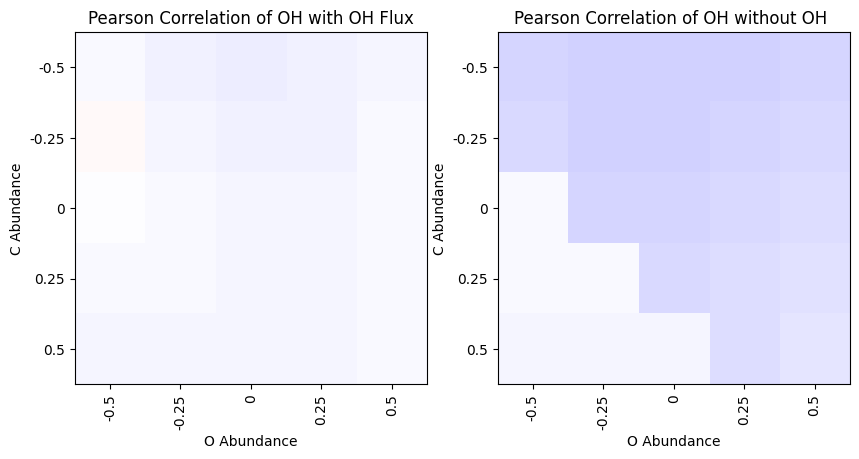

In [17]:
for specie in ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']:
    pearson_corr = []
    pearson_corr_without = []
    for i, row in tqdm(df.iterrows()):
        # if i in [10, 15, 16, 20, 21, 22]:
        #     continue
        wl = row['FLiTs Wavelength']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = row['FLiTs NH3 Flux']
        flux = np.interp(NH3_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(NH3_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=30000)-flux_cont + NH3_flux
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(NH3_wl, specie_wl, specie_flux)
        pearson_corr.append(pearsonr(flux, specie_flux)[0])
        pearson_corr_without.append(pearsonr(flux-specie_flux, specie_flux)[0])
    pearson_corr = np.array(pearson_corr)
    pearson_corr_without = np.array(pearson_corr_without)
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(pearson_corr.reshape(5,5), cmap='seismic',  vmin=-1, vmax=1)
    ax[1].imshow(pearson_corr_without.reshape(5,5), cmap='seismic',  vmin=-1, vmax=1)
    # ax[1].colorbar()
    ax[0].set_title(f"Pearson Correlation of {specie} with {specie} Flux")
    ax[1].set_title(f"Pearson Correlation of {specie} without {specie} ")
    ax[0].set_xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    ax[0].set_yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    ax[1].set_xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    ax[1].set_yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    ax[0].set_xlabel('O Abundance')
    ax[0].set_ylabel('C Abundance')
    ax[1].set_xlabel('O Abundance')
    ax[1].set_ylabel('C Abundance')
    plt.show()

# Layout Thesis

**Front Page**
- Title
- Name
- student id
- supervisors
- daily supervisors
- 2nd corrector

**Abstract**
- Summary of thesis

**Table of Contents**

**Introduction**
- History
- Papers with observations of different molecules
- Objective (detecting molecules that haven't been detected)
- Shape of the thesis (Explaining what is discussed in each chapter

**Theoretical Background**
- General introduction to protoplanetary disks (formation, evolution, etc.)
- Modeling (ProDiMo + FLiTs)
- General theory behind methods

**Methods**
- Explanation of Simulations ran (Parameters)
- Further methods

**Results**
- Results from the methods

**Discussion**
- Comparing to others
- Possible improvements

**Conclusion**
- Summarizing the thesis